In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# from tensorboardX import SummaryWriter

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
fpath = "../../data/DNN_data/v1/"

sig_with_artifact = np.load(fpath + "data_signal_with_sine_regular_pattern" + ".npy")
sig = np.load(fpath + "data_signal" + ".npy")
artifact = sig_with_artifact - sig

print(sig_with_artifact.shape)
print(sig.shape)

(1000, 4000)
(1000, 4000)


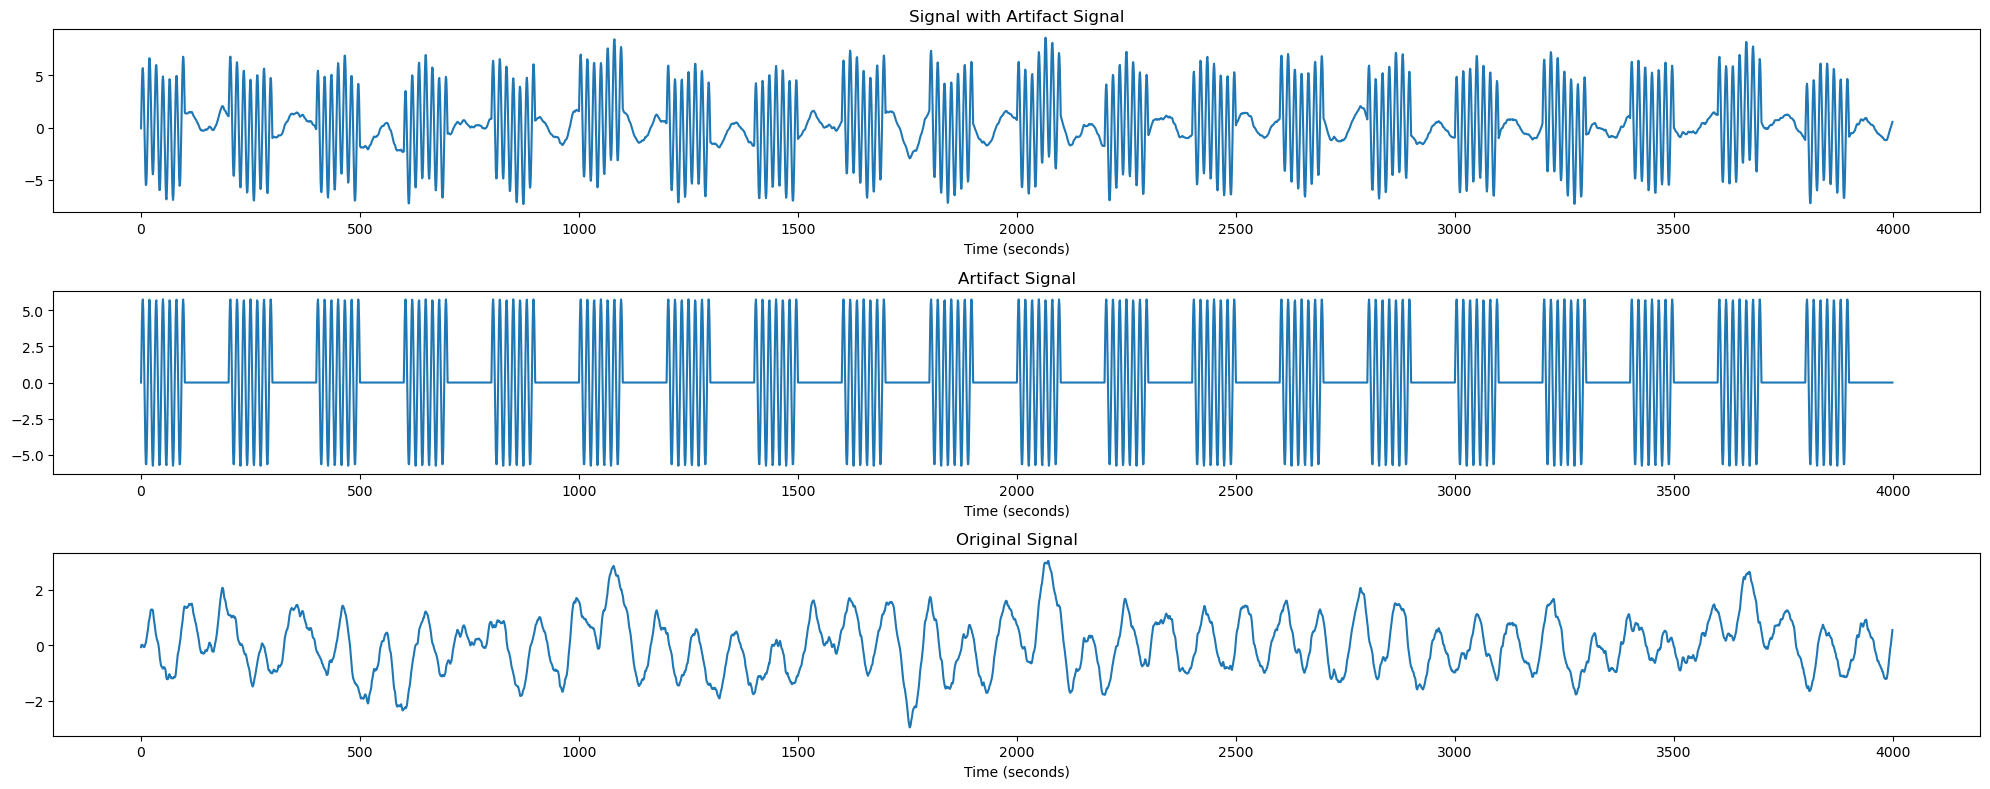

In [3]:
plt.figure(figsize=(20,8))

plt.subplot(3, 1, 1)
plt.plot(sig_with_artifact[0])
plt.xlabel("Time (seconds)")
plt.title('Signal with Artifact Signal')

plt.subplot(3, 1, 2)
plt.plot(artifact[0])
plt.xlabel("Time (seconds)")
plt.title('Artifact Signal')

plt.subplot(3, 1, 3)
plt.plot(sig[0])
plt.xlabel("Time (seconds)")
plt.title('Original Signal')

plt.tight_layout()

In [4]:
sig_with_artifact = sig_with_artifact.transpose()
sig = sig.transpose()

print(sig_with_artifact.shape)
print(sig.shape)

(4000, 1000)
(4000, 1000)


(1000, 4000)
(1000, 4000)


(-3.0, 3.0)

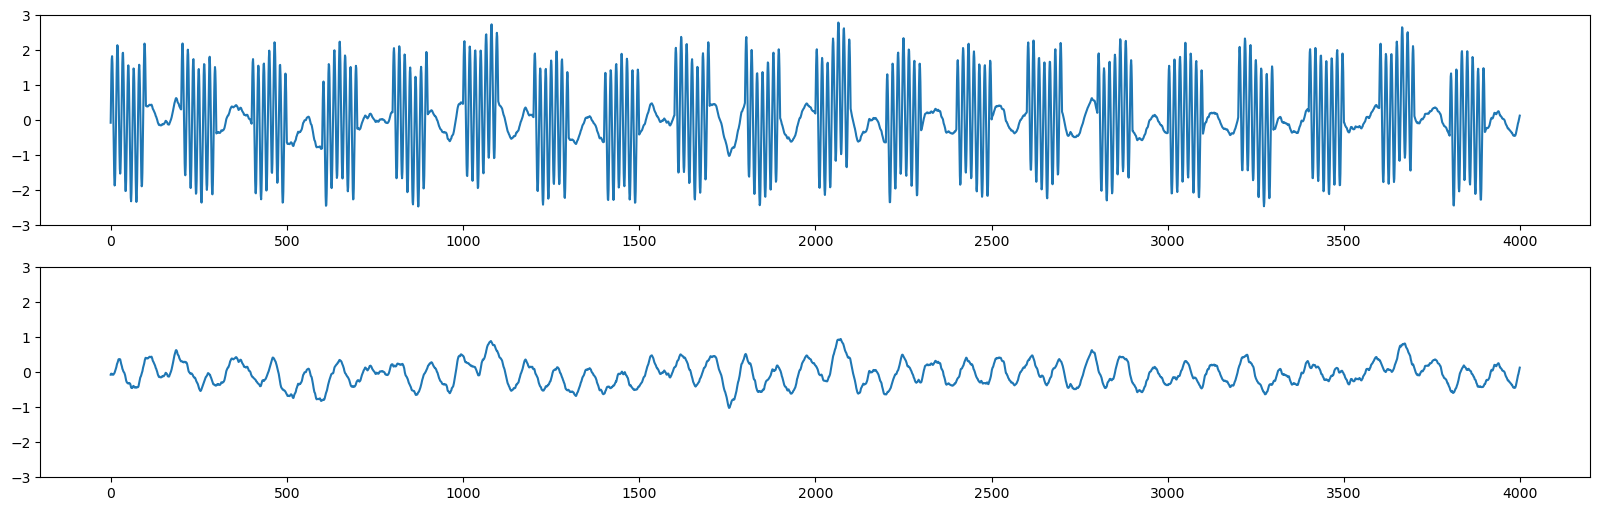

In [5]:
# StandardScaler를 이용하여 정규화
scaler = StandardScaler()
X = scaler.fit_transform(sig_with_artifact)
# y = scaler.fit_transform(sig)
y = (sig-scaler.mean_)/np.sqrt(scaler.var_) # X와 동일한 평균, 표준 편차로 scaling

X = X.transpose()
y = y.transpose()

print(X.shape)
print(y.shape)

plt.figure(figsize=(20, 6))
plt.subplot(2, 1, 1)
plt.plot(X[0])
plt.ylim([-3, 3])
plt.subplot(2, 1, 2)
plt.plot(y[0])
plt.ylim([-3, 3])

In [6]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("-----------------------------")
print("X_train shape: {}\ny_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x T, y : B x T
print("-----------------------------")
print("X_test shape: {}\ny_test shape: {}".format(X_test.shape, y_test.shape))
print("-----------------------------")

X_train = X_train.reshape(X_train.shape[0], 4000, 1)
X_test = X_test.reshape(X_test.shape[0], 4000, 1)

print("<unsqueezed>")
print("-----------------------------")
print("X_train shape: {}\ny_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x 1 x T, y : B x T
print("-----------------------------")
print("X_test shape: {}\ny_test shape: {}".format(X_test.shape, y_test.shape))
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=50, shuffle=False)

-----------------------------
X_train shape: (800, 4000)
y_train shape: (800, 4000)
-----------------------------
X_test shape: (200, 4000)
y_test shape: (200, 4000)
-----------------------------
<unsqueezed>
-----------------------------
X_train shape: (800, 4000, 1)
y_train shape: (800, 4000)
-----------------------------
X_test shape: (200, 4000, 1)
y_test shape: (200, 4000)
-----------------------------


In [7]:
# 인코더 네트워크 생성

class Encoder(nn.Module):    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.input1 = nn.Linear(input_dim, hidden_dim)
        self.input2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)        
        self.training = True
        
    def forward(self, x):
        h_ = self.LeakyReLU(self.input1(x))
        h_ = self.LeakyReLU(self.input2(h_))
        mean = self.mean(h_)
        log_var = self.var(h_)                           
        return mean, log_var # 인코더 네트워크에서 평균과 분산을 반환

In [8]:
# 디코더 네트워크

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h = self.LeakyReLU(self.hidden1(x))
        h = self.LeakyReLU(self.hidden2(h))        
        # x_hat = torch.sigmoid(self.output(h)) # 디코더 결과는 시그모이드를 통과했으므로 0~1 값을 가짐
        x_hat = self.output(h)
        return x_hat 

In [9]:
# VAE 네트워크

class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var): # 평균과 표준편차를 통해 latent vector z를 샘플링
        epsilon = torch.randn_like(var).to(device)                
        z = mean + var*epsilon # z 값 구하기   
        return z
                        
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.Decoder(z)        
        return x_hat, mean, log_var # 디코더 결과와 평균, 표준편차를 반환

In [10]:
# 인코더와 디코더 객체 초기화

x_dim  = 4000
hidden_dim = 400
latent_dim = 40
epochs = 5000
batch_size = 50

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

In [11]:
# 손실 함수 정의

def loss_function(x, x_hat, mean, log_var): # 오차 구하는 함수, KLD를 계산하고 KLD가 줄어드는 방향으로 q(z)를 업데이트
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum') # Loss Function을 BCE에서 MSE로 변경
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss, KLD

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
# 모델 학습 함수 정의 1

# saved_loc = 'scalar/' # 텐서보드에서 사용할 경로
# writer = SummaryWriter(saved_loc) # 텐서보드: 오차와 같은 주요 측정 항목들이 학습 과정에서 어떻게 변하는지 알고자 할 때 사용

model.train()
def train(epoch, model, train_loader, optimizer):
    train_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)

        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        BCE, KLD = loss_function(x, x_hat, mean, log_var)
        loss = BCE + KLD
        # add_scalar: 텐서보드에 오차 등 주요 측정 항목의 결과를 출력할 때 사용
        # writer.add_scalar("Train/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) ) 
        # writer.add_scalar("Train/KL-Divergence", KLD.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        # writer.add_scalar("Train/Total Loss" , loss.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        
        train_loss += loss.item()  
        loss.backward()
        optimizer.step()
          
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(x)))
            
    print("======> Epoch: {} Average loss: {:.4f}".format(
        epoch, train_loss / len(train_loader.dataset)))

In [13]:
# 모델 학습 함수 정의 2

# saved_loc = 'scalar/' # 텐서보드에서 사용할 경로
# import os
# import shutil
# if os.path.exists('scalar/'):
#     # 폴더가 존재하면 폴더 내의 모든 내용을 삭제
#     shutil.rmtree('scalar/')

# writer = SummaryWriter(saved_loc) # 텐서보드: 오차와 같은 주요 측정 항목들이 학습 과정에서 어떻게 변하는지 알고자 할 때 사용

model.train()
def train(epoch, model, train_loader, optimizer):
    train_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        MSE, KLD = loss_function(y, x_hat, mean, log_var)
        loss = MSE + KLD
        # add_scalar: 텐서보드에 오차 등 주요 측정 항목의 결과를 출력할 때 사용
        # writer.add_scalar("Train/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) ) 
        # writer.add_scalar("Train/KL-Divergence", KLD.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        # writer.add_scalar("Train/Total Loss" , loss.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        
        train_loss += loss.item()  
        loss.backward()
        optimizer.step()
          
        # if batch_idx % 100 == 0:
        #     print('Train Epoch: {}\t Loss: {:.6f}'.format(
        #         epoch, loss.item() / len(y)))
    if epoch == 0:
        print(f"Epoch: [{epoch}/{epochs}]\t\tTrain Loss: {train_loss / len(train_loader.dataset):.4f}", end='\t')
    elif epoch%10==0:        
        print(f"Epoch: [{epoch}/{epochs}]\tTrain Loss: {train_loss / len(train_loader.dataset):.4f}", end='\t')

In [14]:
# 모델 평가 함수 정의

def test(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_loader):
            x = x.view(batch_size, x_dim)
            x = x.to(device)   
            y = y.to(device)     
            x_hat, mean, log_var = model(x)
            MSE, KLD = loss_function(y, x_hat, mean, log_var)
            loss = MSE + KLD

            # 테스트 데이터셋에 대해서도 오차를 로그에 저장
            # writer.add_scalar("Test/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            # writer.add_scalar("Test/KL-Divergence", KLD.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            # writer.add_scalar("Test/Total Loss" , loss.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            test_loss += loss.item()

            # if batch_idx == 0:
            #     n = min(x.size(0), 8)
            #     comparison = torch.cat([x[:n], x_hat.view(batch_size, x_dim)[:n]])
            #     grid = torchvision.utils.make_grid(comparison.cpu()) 
            #     writer.add_image("Test image - Above: Real data, below: reconstruction data", grid, epoch)
        if epoch == 0:
            print(f"Test Loss: {test_loss / len(test_loader.dataset):.4f}")
        elif epoch%10==0:        
            print(f"Test Loss: {test_loss / len(test_loader.dataset):.4f}")

In [15]:
# 모델 학습

from tqdm.auto import tqdm
for epoch in tqdm(range(0, epochs)):
    train(epoch, model, train_loader, optimizer)
    test(epoch, model, test_loader)
# writer.close()

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: [0/5000]		Train Loss: 309.5476	Test Loss: 240.1862
Epoch: [10/5000]	Train Loss: 219.7402	Test Loss: 218.7073
Epoch: [20/5000]	Train Loss: 218.3471	Test Loss: 217.0603
Epoch: [30/5000]	Train Loss: 217.6759	Test Loss: 216.1126
Epoch: [40/5000]	Train Loss: 214.1970	Test Loss: 213.5643
Epoch: [50/5000]	Train Loss: 207.8263	Test Loss: 208.1767
Epoch: [60/5000]	Train Loss: 199.8611	Test Loss: 205.4506
Epoch: [70/5000]	Train Loss: 189.9639	Test Loss: 201.2282
Epoch: [80/5000]	Train Loss: 180.4129	Test Loss: 200.0466
Epoch: [90/5000]	Train Loss: 168.8982	Test Loss: 200.3119
Epoch: [100/5000]	Train Loss: 158.7321	Test Loss: 200.2306
Epoch: [110/5000]	Train Loss: 147.8606	Test Loss: 201.9497
Epoch: [120/5000]	Train Loss: 136.3023	Test Loss: 210.8261
Epoch: [130/5000]	Train Loss: 127.5096	Test Loss: 214.3347
Epoch: [140/5000]	Train Loss: 118.9254	Test Loss: 219.5647
Epoch: [150/5000]	Train Loss: 111.1261	Test Loss: 222.1005
Epoch: [160/5000]	Train Loss: 104.4984	Test Loss: 225.2320
Epoch: 

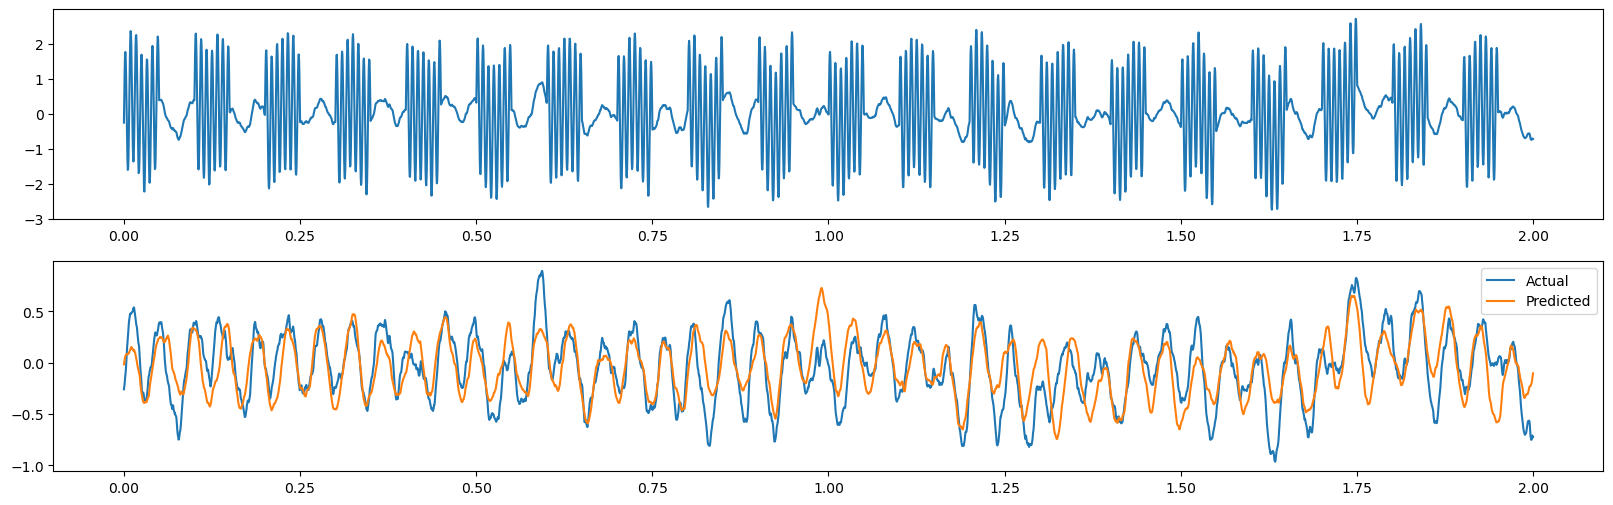

In [16]:
with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_loader):
            x = x.view(batch_size, x_dim)
            x = x.to(device)        
            x_hat, mean, log_var = model(x)

x = x.cpu()
x_hat = x_hat.cpu()

t = np.linspace(0, 2, num=4000)           

plt.figure(figsize=(20,6))

plt.subplot(2, 1, 1)
plt.plot(t, x[0])

plt.subplot(2, 1, 2)
plt.plot(t, y[0], label='Actual')
plt.plot(t, x_hat[0], label='Predicted')
plt.legend()

In [17]:
# 텐서보드에서 오차 확인

# %load_ext tensorboard # magic command
# %tensorboard --logdir scalar --port=6013

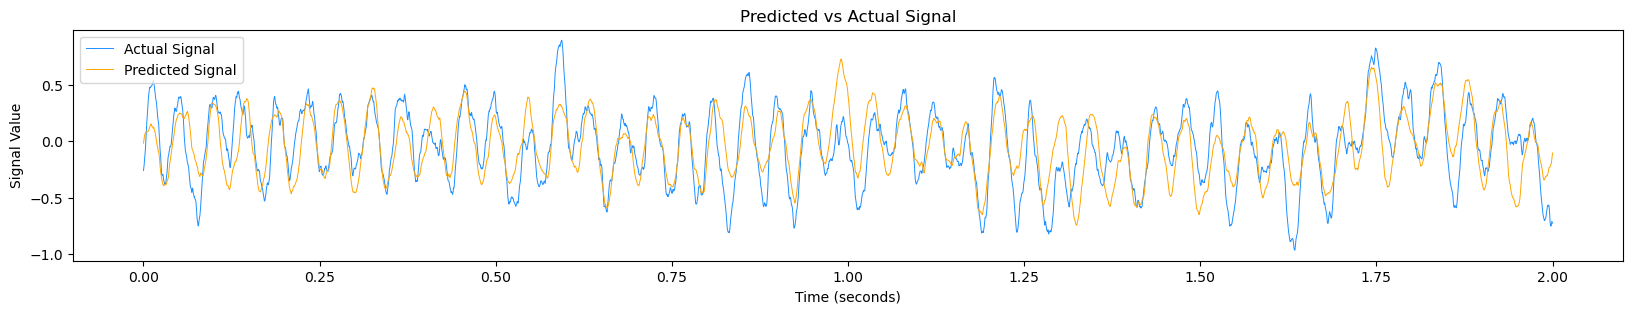

Mean Absolute Error: 0.17941993474960327
Mean Squared Error: 0.05367252975702286


In [18]:
# time domain plotting

predicted_signal = x_hat[0]
actual_signal = y[0]

t = np.linspace(0, 2, num=4000)  

plt.figure(figsize=(20, 3))
plt.plot(t, actual_signal, label='Actual Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.plot(t, predicted_signal, label='Predicted Signal', color='orange', alpha=1, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('Predicted vs Actual Signal')
plt.legend()
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(actual_signal, predicted_signal)}")
print(f"Mean Squared Error: {mean_squared_error(actual_signal, predicted_signal)}")

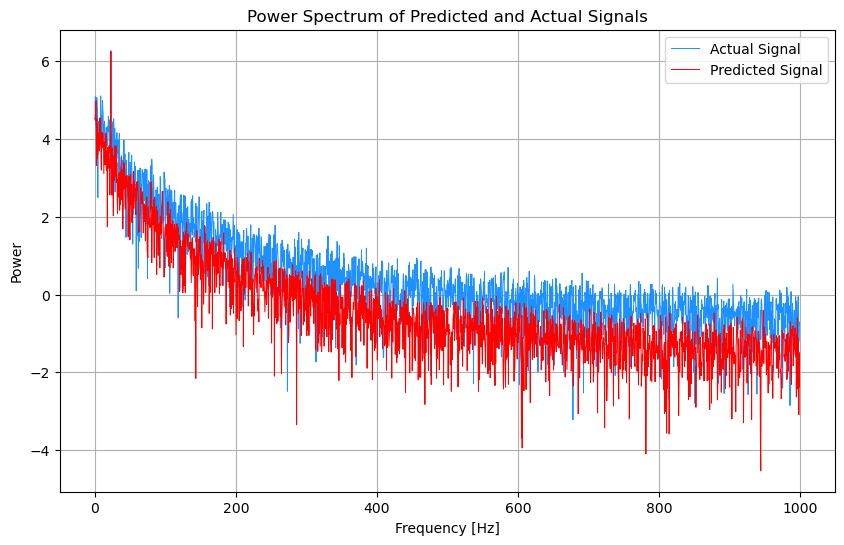

Mean Absolute Error: 0.9255904392562073
Mean Squared Error: 1.2521002350930477


In [19]:
# frequency domain plotting

n = len(predicted_signal)

fs = 2000
freqs = np.fft.fftfreq(n, d=1/fs)[:n//2]

fft_predicted = np.fft.fft(predicted_signal)
fft_predicted = np.abs(fft_predicted[:n//2])
fft_predicted[1:] = 2 * fft_predicted[1:]
power_predicted = fft_predicted**2

fft_actual = np.fft.fft(actual_signal)
fft_actual = np.abs(fft_actual[:n//2])
fft_actual[1:] = 2 * fft_actual[1:]
power_actual = fft_actual**2

# 결과 플로팅
plt.figure(figsize=(10, 6))
plt.plot(freqs, np.log10(power_actual), label='Actual Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.plot(freqs, np.log10(power_predicted), label='Predicted Signal', color='red', alpha=1, linewidth=0.7)
plt.title('Power Spectrum of Predicted and Actual Signals')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(np.log10(power_predicted), np.log10(power_actual))}")
print(f"Mean Squared Error: {mean_squared_error(np.log10(power_predicted), np.log10(power_actual))}")